#### CIE4604 Simulation and Visualization
# Assignment 2 - GNSS-Reflectometry simulation

GPS and other GNSS satellite signals are reflected by the Earth’s oceans. A GNSS-R(eflectrometry) receiver on board a satellite in a low Earth orbit (LEO) is able to receive both the **direct** signal from a GNSS satellite, as well as the signal **reflected** by the surface of the Earth. This will provide very useful information on the Sea state and level in particular

![Remote Sensing geometry of GNSS-R (From: Jales, 2012](Jales2012.png)

For this assignment you are given the task to simulate a GNSS-R(eflectometry) experiment on board the International Space Station (ISS). 

All the Python scripts can be found in `CIE4604-M2-python` that you can download from Brightspace. For the assignment you need the following modules
- `tleplot.py`
- `crsutil.py`
- `specularpoint.py`

You will also need to have `simplekml` installed (See exercise 6). 

The `CIE4604-M2-python` download comes with 8 exercises in Jupyter notebooks. We suggest that you study the Jupyter notebooks first and do the exercises. These already contain a lot of useful material for the assignment, some of which can be re-purposed for the assignment. An other option is to do this assignment in parallel with the exercises.

## Description of the GNSS-R experiment on board the ISS

For the experiment a GNSS-R receiver will be installed on board the ISS. A GNSS-R receiver is able to

1.	Receive the direct signal from Global Navigation Satellite Systems (GNSS), such as the US GPS, Russian GLONASS, European GALILEO and Chinese BEIDOU satellites,
2.	Receive reflected GNSS signals from the Earth surface.

The path delay difference between direct and reflected signal is a measure for the Sea-surface height. However, by recording the full reflected wave form also other parameters about the sea state, such as wave-height and direction, can be retrieved.

The GNSS-R receiver on board the ISS uses two antenna’s, one **upward looking** standard **omnidirectional** antenna for the **direct** signals, and a specially designed **downward looking** antenna for the **reflected** signals. The opening angle of downward antenna (field of view) is not yet decided: the final value will depend on the outcome of the simulation, and will be a trade-off between received power and coverage.

## Breakdown in sub-tasks

The first step of any task is to break it down in more manageable sub-tasks. Normally this is something that you have to do yourself, but here, for this assignment, we will give you the task breakdown. The sub-tasks you have to perform are:

1. Simulate and visualize the ISS orbit trajectory
2. Simulate and visualize the GPS satellite orbits
3. Simulate and visualize GNSS signals from the upward looking omnidirectional antenna on the ISS (direct signals)
4. Simulate and visualize GNSS signals from the down looking antenna on the ISS (reflected signals)

More details on each sub-task can be found in the following cells.

## 1. Simulate and visualize the ISS orbit trajectory


In [115]:
import matplotlib.pyplot as plt
import tleplot as tle
import crsutil as crs
import numpy as np
from scipy.io import loadmat


In [116]:
def scircle1(lat0,lon0,theta):
    
    slat0 = np.sin(np.deg2rad(lat0))
    clat0 = np.cos(np.deg2rad(lat0))

    stheta = np.sin(np.deg2rad(theta))
    ctheta= np.cos(np.deg2rad(theta))
    
    alpha = np.deg2rad( np.arange(0,360,10) )
    
    lat = np.arctan2( slat0*ctheta + clat0*stheta*np.cos(alpha) ,
         np.sqrt( (clat0*ctheta - slat0*stheta*np.cos(alpha))**2 + (stheta *np.sin(alpha))**2 ))
    dlon = np.arctan2( stheta * np.sin(alpha) , clat0*ctheta - slat0*stheta*np.cos(alpha) )

    lat = np.rad2deg(lat)
    lon = lon0 + np.rad2deg(dlon)

    return lat, lon


Simulate and visualize the orbit trajectory of the International Space Station ISS. You may use Two-Line Elements (TLE) for ISS (Zarya) that you can find on Celestrak. The questions need to be answered in this sub-task:

a.	What are the main limitations of using GNSS-R from the ISS for the spatial and temporal coverage?
Hint: To answer this question you have to plot the ISS ground tracks (sub-satellite tracks), for which you may use `pltgroundtracks` from the `tleplot` Python module. 


In [117]:
# get the most recent 
tle.tleget('stations')
tleERS = tle.tleread('stations.txt',verbose=0)

Saving TLE set to default name
TLEGET: Downloaded stations.txt from http://celestrak.com/NORAD/elements/
Saved TLE to stations.txt


Found 1 satellites:
 ISS (ZARYA)  (0)


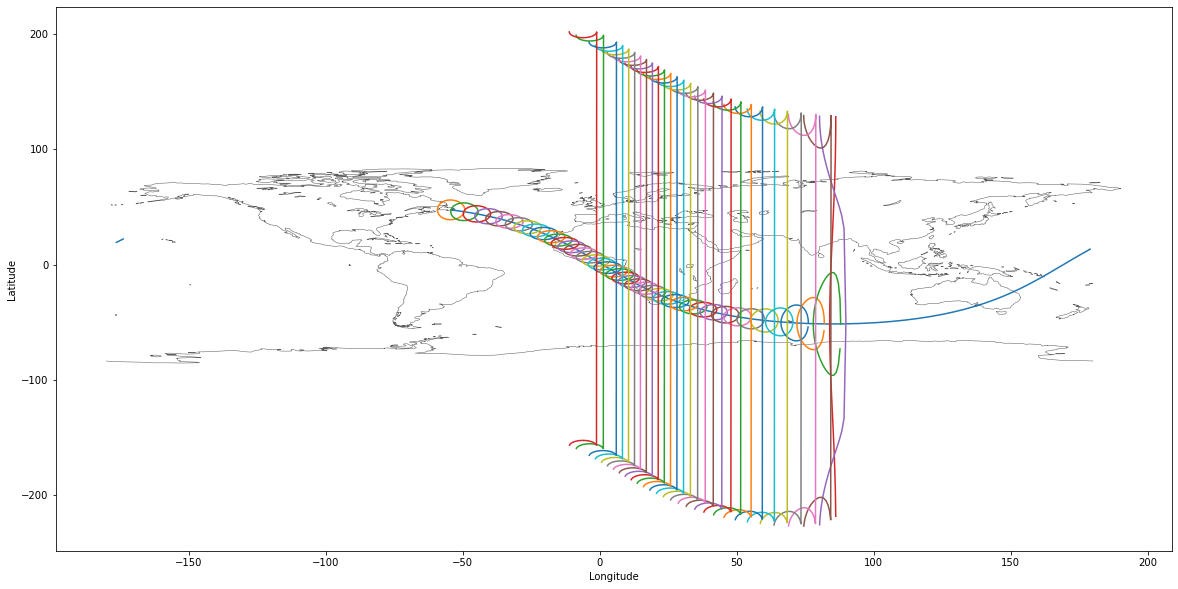

In [133]:
isat,name = tle.tlefind(tleERS,'ISS (ZA')
t = tle.tledatenum(['2021-11-28 0:00:00', 0.05*24*60 ,1])
iss_xvals,iss_vvals = tle.tle2vec(tleERS,t,'ISS (ZA')
iss_xvalse,iss_vvalse = crs.eci2ecef(t,xsat=iss_xvals,vsat=iss_vvals)


plt.figure(figsize=(20,10))
#tle.pltgroundtrack(iss_xvalse,)
coast = loadmat('coast.mat')

plt.plot(coast["long"], coast["lat"], color=(0.35, 0.35, 0.35), linewidth=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# using code from the Tleplot

lsat = np.arctan2(iss_xvalse[:,1], iss_xvalse[:,0]) * 180 / np.pi
dsat = np.arctan(iss_xvalse[:,2] / np.sqrt(iss_xvalse[:,1]**2 + iss_xvalse[:,0]**2) )  * 180 / np.pi

lsatmask = np.ma.array(lsat)
dsatmask = np.ma.array(dsat)
lsatmask[np.hstack([False,np.abs(np.diff(lsat)) > 180])] = np.ma.masked 
dsatmask[np.hstack([False,np.abs(np.diff(dsat)) > 90])] = np.ma.masked 

plt.plot(lsatmask, dsatmask, label='ISS Zarya')


for l,d in zip(lsatmask,dsatmask):
    sc_lat,sc_lon = scircle1(l,d,5)
    
    sc_lat

    # plt.plot(l,d,marker='o')
    # plt.plot(lsatmask_loop,dsatmask_loop)
    plt.plot(sc_lat,sc_lon)



c.	Over how many hours or days do you have to carry out the simulation so that all areas, that can possibly be observed, are observed?  

In all steps we expect clear answers with a brief explanation. Include appropriate plots and visualizations wherever necessary.

## 2. Simulate and visualize the GPS satellite orbits

Simulate and visualize the GPS orbits. You may again use TLE from Celestrak. Deliverables for this sub-task are:

a.	Plot of the GPS ground tracks.  You may again use `pltgroundtracks` from the `tleplot` module. Please think carefully about how to plot this data in a nice and concise manner, as there are about 30 operational GPS satellites.

b.	Polar plot (skyplot), using the azimuth and zenith angles, for a station on the Earth (e.g. Delft).  Hint: You may use the function `skyplot` from the `tleplot`  module. 

c.	Plot with the number of GPS satellite in view as function of time for the same ground station. Consider carefully how you define visibility and which value you use as elevation cut-off angle. Hint: As an intermediate step, create a 2D boolean array with an axis for satellite, and an axis for time, with True whenever a satellite is visible.

You may use a period of one day for these plots.

In [5]:
# enter here your code and run the cell to produce the result, if you wish you can use more cells

gpsERS = tle.tleread('GPS.txt')



Satellite              Reference_Epoch    a [km]    ecc [-]  inc [deg] RAAN [deg] argp [deg]    E [deg]    Period

GPS BIIR-2  (PRN 13)    2021-323.95874  26560.41  0.0055137    55.4848   163.8466    54.6603   305.9227  11:57:59
GPS BIIR-4  (PRN 20)    2021-324.45221  26560.55  0.0054584    53.8933    87.5145   176.4219   267.5614  11:57:59
GPS BIIR-8  (PRN 16)    2021-324.12827  26559.16  0.0122233    55.6614   281.3700    38.3106   147.9321  11:57:56
GPS BIIR-9  (PRN 21)    2021-324.59468  26559.73  0.0244942    54.9362    31.7750   299.2193    83.4787  11:57:57
GPS BIIR-10 (PRN 22)    2021-324.14935  26560.43  0.0069185    53.7046    90.1603   308.5499    50.8087  11:57:59
GPS BIIR-11 (PRN 19)    2021-324.13867  26560.22  0.0087298    56.1171   342.2933   113.8937   242.5971  11:57:58
GPS BIIR-13 (PRN 02)    2021-324.28216  26561.60  0.0207641    55.2675    31.8491   275.3001    93.5475  11:58:02
GPS BIIRM-1 (PRN 17)    2021-324.19283  26560.61  0.0139757    56.1925   339.7147   27

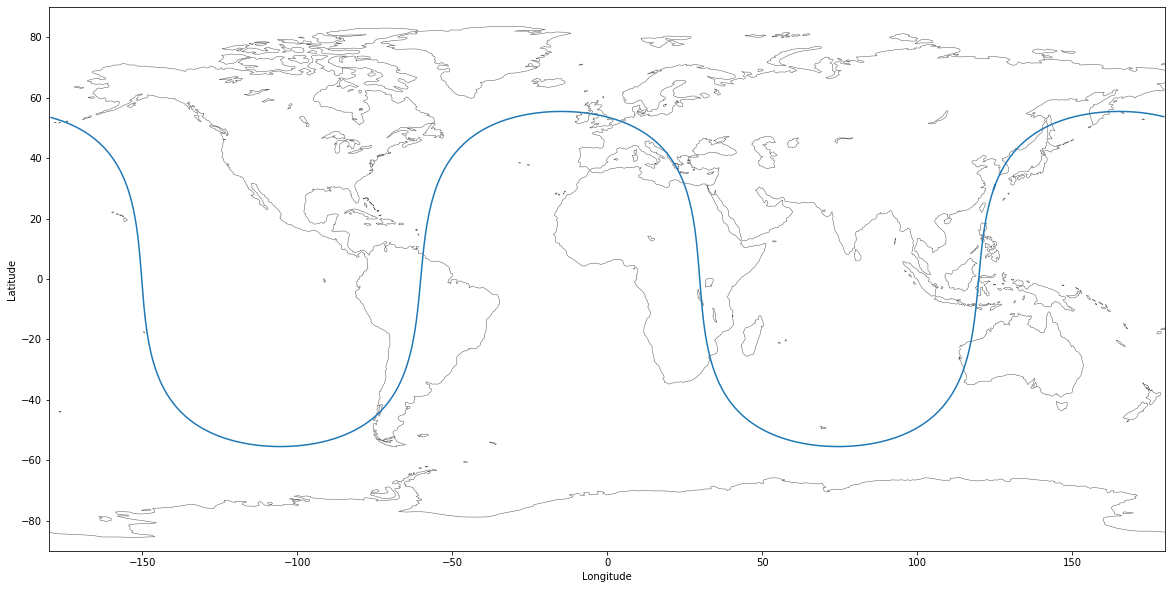

In [6]:

t = tle.tledatenum(['2021-11-23 0:00:00', 24*60 ,1])
xsat,vsat = tle.tle2vec(gpsERS,t,'GPS BIIR-2')
xsate,vsate = crs.eci2ecef(t,xsat=xsat,vsat=vsat)
plt.figure(figsize=(20,10))
tle.pltgroundtrack(xsate)


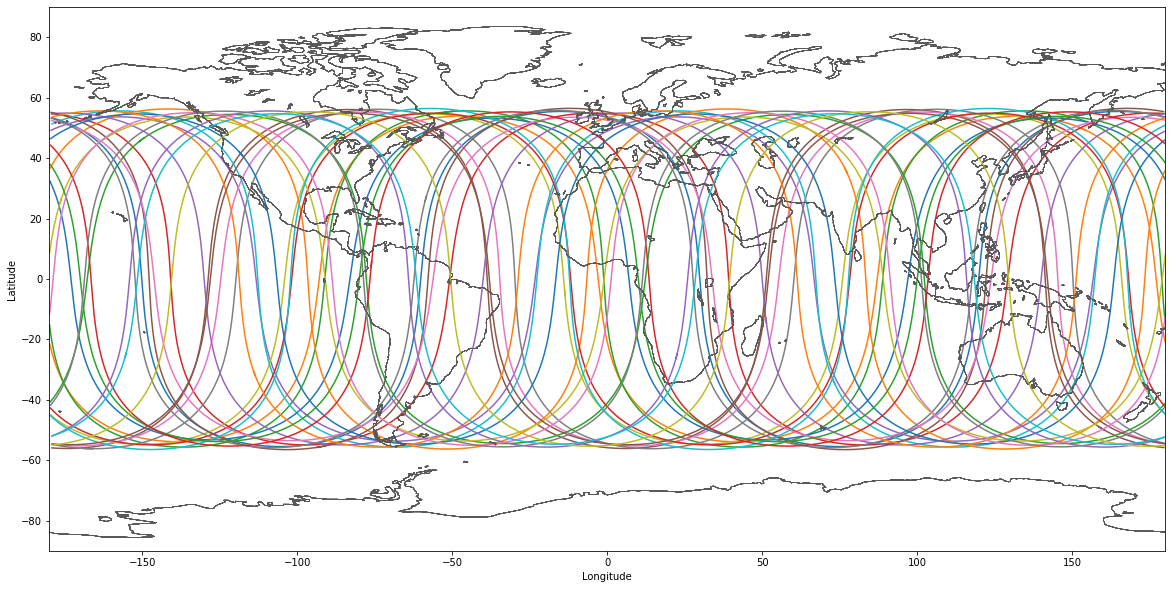

In [7]:
plt.figure(figsize=(20,10))
for sat in gpsERS:
    t = tle.tledatenum(['2021-11-15 0:00:00', 24*60 ,1])
    xsat,vsat = tle.tle2vec(gpsERS,t,sat.name)
    xsate,vsate = crs.eci2ecef(t,xsat=xsat,vsat=vsat)
    tle.pltgroundtrack(xsate)


<Figure size 432x288 with 0 Axes>

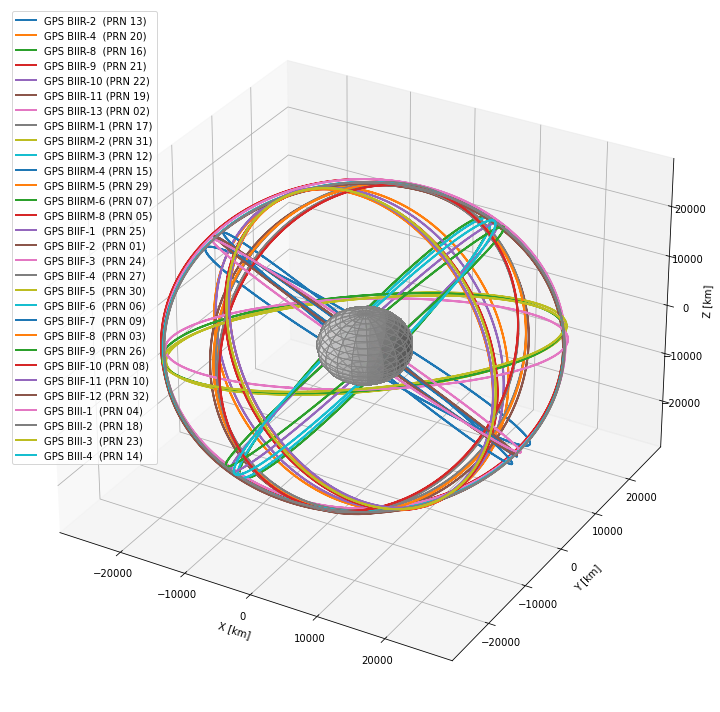

In [8]:
plt.clf()
fig = plt.figure("3D satellite orbit (ECI)",figsize=(20,10), tight_layout=True)
ax = fig.add_subplot(121, projection='3d')
for sat in gpsERS:
    t = tle.tledatenum(['2021-11-15 0:00:00', 24*60 ,1])
    xsat,vsat = tle.tle2vec(gpsERS,t,sat.name)
    xsate,vsate = crs.eci2ecef(t,xsat=xsat,vsat=vsat)
    # modified the plot_orbit_3d to pass extra parameters to the plt.plot() that actually adds the lines.
    tle.plot_orbit_3D(ax,xsat,label=sat.name)

plt.legend()

*Enter here your answers using markdown. Use one cell for each subquestion.*

In [9]:
nepo = t.shape[0]
ngps = len(gpsERS)
zgps = np.full([nepo,ngps],np.nan)
agps = np.full([nepo,ngps],np.nan)

latlon = np.radians([ 52, 4.8 ])
xobje = 6378136 * [ np.cos(latlon[1]) * np.cos(latlon[2]) , 
    np.cos(latlon[1]) * np.sin(latlon[2]) ,
    np.sin(latlon[1])]

for k in range(ngps):
    xgpsi, vgpsi = tle.tle2vec(gpsERS, t, k)
    xgpse, vgpse = crs.eci2ecef(t, xgpsi, vgpsi)
    lookangles, _ = crs.satlookanglesp(t, [xgpse, vgpse], xobje)
    zgps[:,k] = lookangles[:,1]
    agps[:,k] = lookangles[:,2]
    

skyplot(t, agps, zgps, cutoff=10)

IndexError: index 2 is out of bounds for axis 0 with size 2

## 3. Simulate and visualize direct signals

Simulate and visualize GNSS signals from the **upward looking omnidirectional** antenna on the ISS (direct signals). The opening angle of the upward looking antenna is 160 degrees (comparable to a 10 degree elevation cut-off angle). For this sub-task you have to use the simulated ISS and GPS positions from the previous sub-tasks. Questions to answer are:

a.	How many GPS satellites are on average in view from the upward looking antenna? Illustrate this by a plot with the number of GPS satellite in view as function of time from the ISS (as in 2c). How does this compare to a station on the Earth (e.g. Delft)?

b.	What is the average duration of GPS satellite visibility, in minutes from start to end for each pass, from the ISS? Include a plot that clearly illustrates this answer. Again, how does this compare to the a station on the Earth?

c.	Visualize the ISS, GPS and observations from the upward looking omnidirectional antenna in Google Earth using the `simplekml` Python module. You may get some inspiration from exercise 6 `CIE4604-M2-Example6_kml.ipynb` notebook. Make separate kml folders (within the same kmz file) for ISS, GPS and direct observations. For the report (Jupyter notebook), include a screenshot showing trajectories for one day, but the direct observations only for a single epoch.

You may use a period of one day for the plots. 

In [ ]:
# enter here your code and run the cell to produce the result, if you wish you can use more cells

*Enter here your answer using markdown. Use one cell for each sub-question. For question 3c do not forget to include the screenshot, you can do this with syntax like `![](screenshot.png)`*.

## 4. Simulate and visualize reflected signals


Simulate and visualize GNSS signals from the **downward looking** antenna on the ISS (reflected signals). The opening angle of the downward looking antenna is 40 degrees or 100 degrees.

a.	Make a function to compute the position of  the specular reflection points that are within the field of view (opening angle) of the down looking GPS antenna on board the ISS at a specified moment in time. 

Input for this function is:  the position of the ISS and  GPS satellite positions at a specific time (one epoch only), and the opening angle of the downward looking antenna (40 or 100 degrees). The output should be the position of the specular reflection points (zero, one or more) that fall within the opening angle. For the actual computation you may call the function `specularpoint` from the `specularpoint.py` module that is part of the `CIE4604_M2_Python.zip` distribution. This is also explained in more detail in exercise 8 `CIE4604_M2_Example8_sp.ipynb` notebook.

b.	Make a plot with the specular reflection points, ISS and GPS ground tracks in Python for a period of several minutes for two different values of the opening angle.

c.	Visualize the specular reflection points and reflected signals in Google Earth for two different values of the opening angle (40 degrees and 100 degrees), and add this to the kmz file of question 3c. Make a new kml folder (within the same kmz file) for each opening angle. 

Include in your report a screenshot of Google Earth showing the ISS, GPS and specular reflection point trajectories for a period of several minutes, while showing the direct and reflected signals only for a single epoch.

In [ ]:
# enter here your code and run the cell to produce the result, if you wish you can use more cells

*Enter here your answer using markdown. Use one cell for each sub-question. For question 3c do not forget to include the screenshot, you can do this with syntax like `![](screenshot.png)`*.

# Deliverables

The deliverables for this assignment are 

1.	Pdf of your Jupyter notebook or short report (pdf)  with a description of the GNSS-R simulator, plots of the results and answers to the questions.
2.	KMZ file (for display in Google Earth), one kmz file only, for question 3c and 4c combined.
3.	Jupyter notebook or zip file with the code.

The above deliverables have to be submitted electronically  through Brightspace.


[End of this Jupyter notebook]